In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
muratkokludataset_rice_image_dataset_path = kagglehub.dataset_download('muratkokludataset/rice-image-dataset')

print('Data source import complete.')

Data source import complete.


## Import Libraries

In [2]:
# Install libraries
!pip install packaging==23.2
!pip install tensorflowjs

In [3]:
# Import libraries
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import tensorflowjs as tfjs

from sklearn.model_selection import train_test_split

from google.colab import files
from IPython.display import Image as IPyImage, display

## Data Preparation

### Data Loading

In [4]:
# Load dataset and check images
dir_dataset = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'
categories = ['Arborio', 'Basmati', 'Ipsala']
valid_ext = ['.jpg', '.jpeg', '.png']

def analyze_images(directory, categories, valid_ext):
    all_images = glob.glob(os.path.join(directory, '*', '*.*'))
    filtered_images = [
        img for img in all_images
        if os.path.basename(os.path.dirname(img)) in categories and os.path.splitext(img)[1].lower() in valid_ext
    ]

    print("Total images in all categories\t\t:", len(all_images))
    print("Total images in selected categories\t:", len(filtered_images))

    for category in categories:
        path = os.path.join(directory, category)
        files = [
            f for f in os.listdir(path)
            if os.path.splitext(f)[1].lower() in valid_ext
        ]
        print(f"Total {category} images \t\t\t: {len(files)}")

        sizes = set()
        for f in files:
            try:
                with Image.open(os.path.join(path, f)) as img:
                    sizes.add(img.size)
            except Exception as e:
                print(f"- Error reading {f}: {e}")
        sizes_str = ', '.join(str(s) for s in sizes)
        print(f"{category} resolutions\t\t\t: {sizes_str}")

    return filtered_images

### Data Preprocessing

#### Data Splitting

In [5]:
# Filter only selected categories and split the dataset
filtered_images = analyze_images(dir_dataset, categories, valid_ext)

labels = [os.path.basename(os.path.dirname(path)) for path in filtered_images]
df = pd.DataFrame({'filename': filtered_images, 'label': labels})

train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Train\t\t\t\t\t: {len(train_df)}")
print(f"Val\t\t\t\t\t: {len(val_df)}")
print(f"Test\t\t\t\t\t: {len(test_df)}")

Total images in all categories		: 75000
Total images in selected categories	: 45000
Total Arborio images 			: 15000
Arborio resolutions			: (250, 250)
Total Basmati images 			: 15000
Basmati resolutions			: (250, 250)
Total Ipsala images 			: 15000
Ipsala resolutions			: (250, 250)
Train					: 36000
Val					: 4500
Test					: 4500


In [6]:
# Create data generators with preprocessing and optional shuffling
img_height, img_width = 224, 224
batch_size = 32

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

def create_generator(dataframe, shuffle):
    return datagen.flow_from_dataframe(
        dataframe,
        x_col='filename',
        y_col='label',
        target_size=(img_height, img_width),
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=shuffle
    )

train_gen = create_generator(train_df, shuffle=True)
val_gen = create_generator(val_df, shuffle=False)
test_gen = create_generator(test_df, shuffle=False)

Found 36000 validated image filenames belonging to 3 classes.
Found 4500 validated image filenames belonging to 3 classes.
Found 4500 validated image filenames belonging to 3 classes.


## Training

In [7]:
# Create callbacks
class AccuracyThresholdCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        if acc and val_acc and acc > 0.96 and val_acc > 0.96:
            print("\nAccuracy and val_accuracy > 96%. Training stopped.")
            self.model.stop_training = True

In [8]:
# Build model using CNN
model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(df['label'].unique()), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,147 (430.26 KB)

 Trainable params: 110,147 (430.26 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Check accuracy and val_accuracy
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    AccuracyThresholdCallback()
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 104s 86ms/step - accuracy: 0.8206 - loss: 0.3626 - val_accuracy: 0.9978 - val_loss: 0.0113 - learning_rate: 0.0010
Epoch 2/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9930 - loss: 0.0225
Accuracy and val_accuracy > 96%. Training stopped.
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 97s 86ms/step - accuracy: 0.9930 - loss: 0.0225 - val_accuracy: 0.9982 - val_loss: 0.0107 - learning_rate: 0.0010


## Evaluation and Visualization

In [10]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen)

141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.9955 - loss: 0.0149


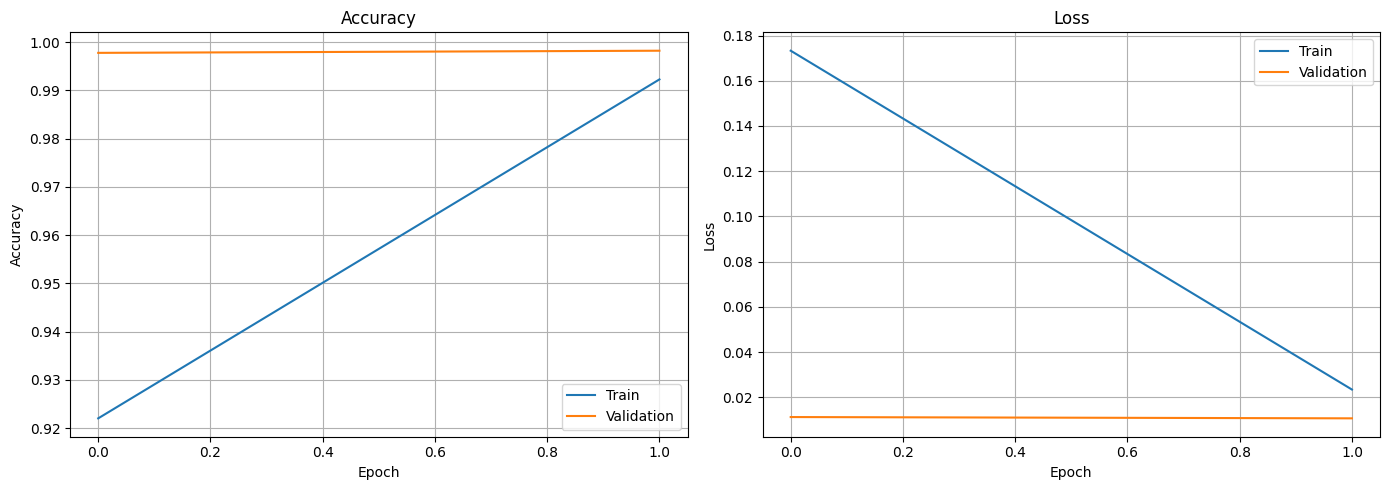

In [11]:
# Plot training & validation accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(history.history['accuracy'], label='Train')
ax[0].plot(history.history['val_accuracy'], label='Validation')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(history.history['loss'], label='Train')
ax[1].plot(history.history['val_loss'], label='Validation')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

## Model Conversion

In [12]:
# Save the model
model.export('saved_model')

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  136362030071440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136362030070288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136364662422800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136362030751312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136362030752656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136362030753232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136364662421840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136362030753616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136362030754000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136362030755536: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [13]:
# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

In [14]:
# Save the labels
class_labels = list(train_gen.class_indices.keys())
with open('tflite/label.txt', 'w') as f:
    for label in class_labels:
        f.write(label + '\n')

In [15]:
# Convert the model to TensorFlow.js
tfjs.converters.save_keras_model(model, 'tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

Saving Ipsala.jpg to Ipsala.jpg


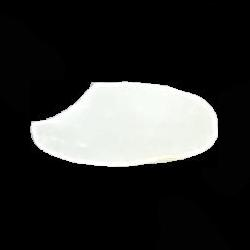

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
Predicted label: Ipsala (Confidence: 1.00)


In [16]:
# Inference
def upload_and_predict_colab():
    uploaded = files.upload()
    for fn in uploaded.keys():
        img_path = fn
        img = image.load_img(img_path, target_size=(224, 224))

        display(IPyImage(filename=img_path))

        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        preds = model.predict(x)
        class_indices = train_gen.class_indices
        labels = [None]*len(class_indices)
        for label, idx in class_indices.items():
            labels[idx] = label

        predicted_class_idx = np.argmax(preds[0])
        predicted_label = labels[predicted_class_idx]
        confidence = preds[0][predicted_class_idx]

        print(f"Predicted label: {predicted_label} (Confidence: {confidence:.2f})")

upload_and_predict_colab()

## Requirements

In [17]:
!pip freeze > requirements.txt